# CH7 Recurrent Neural Networks and LSTM

The topics:
* Getting an idea of how recurrnet neural networks works and the main operation types used in building them
* Explain the ideas implemented in more advanced models, like LSTM
* Applying an LSTM model in TensorFlow to predict energy consumption cycles
* Compose new music, starting with a series of studies from J.S Bach

## Recurrent neural networks

Recurrent neural networks(RNN) can be defined by a sequential model of neural networks, which have the property of reusing information already given. One of their assumptions is that the current information has a dependency on previous data. In the following figure, we observe a simplified diagram of a RNN basic element, called "Cell":
<figure>
    <img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png"/>
    <figcaption>RNN cell.(http://colah.github.io/posts)</figcaption>
</figure>


The main information elements of a cell are the input $X_{t}$, an state, and an ouput $h_{t}$. But as we said before, cells have not an independent state, so it stores also state information. In the previous figure we showed an "unrolled" RNN cell, showing how it goes from the initial state, to outputting the final $h_{n}$ value, with some intermediate states in between

|![image](https://cdn-images-1.medium.com/max/1600/1*kbL67eKOHPOa_a_F4n8QTw.png)|
|:--:|
|RNN cell, https://cdn-images-1.medium.com/max/1600/1*kbL67eKOHPOa_a_F4n8QTw.png|

Once we define the dynamics of the cell, the next objective would be to investigate the contents of what makes or defines an RNN cell. In the most common case of standard RNN, there is simply a neural network layer, which takes the input, and the previous state as inputs, applies the tanh operation, and outputs the new state $h_{t+1}$. This simple setup is able to sum up information as the epochs pass, but further experimentation showed that for complex knowledge, the sequence distance makes difficult to relate some contexts seems like a simple structure to remember, but the context needed for them for being associated, requires an increasing sequence to be able to relate both concepts. This also brings the associated issue of exploding and vanishing gradients.

## Exploding and vanishing gradients

One of the main problems of RNN happens in the back propagation stages, given its recurrent nature, the number of steps that the back propagation of the errors has is one corresponding th a very deep network. This cascade of gradient calculations could lead to a very non significant value on the last stages, or in the contrary, to ever increasing and unbounded parameter. Those phenomena receive the name of vanishing and exploding gradients. This is one of the reasons for which LSTM architecture was created.

## LSTM neural networks

The **Long Short - Term Memory(LSTM)** is a specific RNN architecture whose special architecture allows them to represent long term dependencies. Moreover, they are specifically designed to remember information patterns and information over long periods of time.
![Problem of RNN](https://image.slidesharecdn.com/computervisionlabseminardeeplearningyonghoon-150925004127-lva1-app6892/95/computer-vision-lab-seminardeep-learning-yong-hoon-56-638.jpg?cb=1443141791)
*Problem of RNN(https://www.slideshare.net/YonghoonKwon1/computer-vision-lab-seminardeep-learning-yong-hoon)*

### The gate operation - a fundamental component
In order to better understand the building blocks of the internal of the LSTM cell, we will describe the main operational block of the LSTM: the gate operation. This operation basically has a multivariate input, and in this block we decide to let some of the inputs go through, and block the other. We can think of it as an information filter, and contributes mainly to allow for getting and remembering the needed information elements. In order to implement this function, we take a multivariate control vector, which is connected with a neural network layer with a sigmoid activation function. Applying the control vector and passing through the sigmoid function, we will get a binary like vector. After defining that binary vector, we will multiply the input function with the vector so we will filter it, letting only parts of the information to get through.

|![LSTM cell](https://deeplearning4j.org/img/greff_lstm_diagram.png)|  
|:--:|  
|https://deeplearning4j.org/lstm.html|

The previous figure tries to show all concepts going on the operation of one LSTM Cell.
As the inputs we have:
* The cell state, which will store long term information, because it carries on the optimized weights from the starting coming from the origin of the cell training, and
* The short term state, $h_{t}$, which will be used directly combined with the current input on each iteration, and so it will have a much bigger influence from the latest values of the inputs.
And as outputs, we have, the result of combining the application of all the gate operations.


## Other RNN architectures
* LSTM with peepholes: In this networks the cell gates are connected to the cell state
* Gate Recurring Unit: It's a simpler model with combines the forget and input gates, merges the state and hidden state of the cell, and so simplifies a lot the training of the net.

## TensorFlow LSTM useful classes and methods
### class tf.nn.rnn_cell.BasicLSTMCell
This class is basic LSTM recurrent network cell, with a forget bias, and has no fancy characteristics of other related types, like peep-holes, that allow the cell to take a look on the cell state even on stages where it's not supposed to have an influence on the results.
The following are the main parameters:
* num_units: Int, the number of units of the LSTM cell
* forget_bias: Float, This bias(default 1) is added to the forget gates in order to allow the first iterations to reduce the loss of information for the initial training steps.
* activation: It is the activation function of the inner states.(The default is the standard *tanh*)

### class MultiRNNCell(RNNCell)
In the architectures we will be using for this particular example, we won't be using a single cell to take in account the historical values. In this case we will be using a stack of connected cells. For this reason we will be instantiating the *MultiRNNCell* class.
*MultiRNNCell(cells, state_is_tuple = False)*
This is the constructor for the *MultiRNNCell*, the main argument of this method is cells, which will be an instance of *RNNCells* we want to stack.

### learn.ops.split_squeeze(dim, num_split, tensor_in)
This function split the input on a dimension, and then it squeezes the previous dimension the splitted tensor belonged. It takes the dimension to cut, the number of ways to split, and then tensor to split. It return the same tensor but with one dimension reduced.

## Example 1 - univariate time series prediction with energy consumption data

### Dataset description and loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/elec_load.csv',error_bad_lines=False)
plt.subplot()
plot_test, = plt.plot(df.values[:1500],label='Load')
plt.legend(handles=[plot_test])
plt.show()

### Dataset preprocessing

In [4]:
df.describe()

,Load
count,140256.000000
mean,145.332503
std,48.477976
min,0.000000
25%,106.850998
50%,151.428571
75%,177.557604
max,338.218126


In [2]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
df_std = pd.DataFrame(stdscaler.fit_transform(df.values))

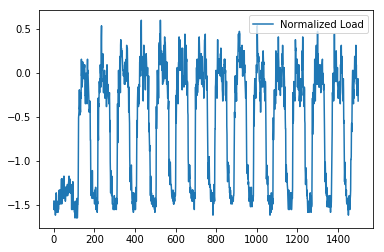

In [22]:
plt.plot(df_std.values[:1500],label='Normalized Load')
plt.legend()
plt.show()

### Model architecture

In [19]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import rnn
from tensorflow.python.framework import dtypes


def lstm_model(time_steps, rnn_layers,dense_layers=None,optimizer='Adagrad',learning_rate=0.01):
    def lstm_cells(layers):
        return [tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],state_is_tuple=True) for layer in layers]
    
    def dnn_layers(input_layers, layers):
        return input_layers
    
    def _lstm_model(X,y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers),state_is_tuple=True)
        x_ = tf.unstack(X,num=time_steps,axis=1)
        output, layers = rnn.static_rnn(stacked_lstm,x_,dtype=dtypes.float32)
        output = dnn_layers(output[-1],dense_layers)
        prediction, loss = learn.models.linear_regression(output,y)
        train_op = tf.contrib.layers.optimize_loss(loss,
                                                  tf.contrib.framework.get_global_step(),
                                                  optimizer=optimizer,
                                                  learning_rate = tf.train.exponential_decay(learning_rate,
                                                                                            tf.contrib.framework.get_global_step(),
                                                                                             decay_steps=1000,decay_rate=0.9,
                                                                                            staircase=False,name=None))
        print('learning_rate',learning_rate)
        return prediction,loss,train_op
    return _lstm_model

### Train and evaluate

In [28]:
import numpy as np

from tensorflow.contrib import learn
from tensorflow.contrib.learn import SKCompat
from sklearn.metrics import mean_squared_error


LOG_DIR = 'log/elec'
TIMESTEPS = 5
RNN_LAYERS = [{'steps': TIMESTEPS}]
DENSE_LAYERS = None
TRAINING_STEPS = 10000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

regressor = SKCompat(learn.Estimator(model_fn=lstm_model(TIMESTEPS,RNN_LAYERS,DENSE_LAYERS),
                                    model_dir=LOG_DIR))

# Create train, valid, test sets
array = df_std.values
listX = []
listy = []
X={}
y={}

for i in range(0,len(array)-6):
    listX.append(array[i:i+5].reshape([5,1]))
    listy.append(array[i+6])
arrayX = np.array(listX,dtype=np.float32)
arrayy = np.array(listy,dtype=np.float32)

X['train'] = arrayX[0:12000]
X['test'] = arrayX[12000:13000]
X['val'] = arrayX[13000:14000]
y['train'] = arrayy[0:12000]
y['test'] = arrayy[12000:13000]
y['val'] = arrayy[13000:14000]

# Save graph
sess = tf.Session()
tf.train.write_graph(sess.graph,'log/elec/graph','graph.pbtxt')

# Create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'],y['val'],
                                                      every_n_steps=PRINT_STEPS,early_stopping_rounds=1000)
regressor.fit(X['train'],y['train'],monitors=[validation_monitor],steps=TRAINING_STEPS)

predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test'])**2).mean(axis=0))
score = mean_squared_error(predicted,y['test'])
print('MSE: %f'%score)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000204E8499390>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'log/elec'}
learning_rate 0.01
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from log/elec\model.ckpt-10004
INFO:tensorflow:Saving checkpoints for 10005 into log/elec\model.ckpt.
learning_rate 0.01
INFO:tensorflow:Starting evaluation at 2018-01-05-07:13:50
INFO:tensorflow:Restoring parameters from log/e

INFO:tensorflow:loss = 0.0363457, step = 17005 (1.175 sec)
INFO:tensorflow:global_step/sec: 303.278
INFO:tensorflow:loss = 0.0470194, step = 17105 (0.320 sec)
INFO:tensorflow:global_step/sec: 305.606
INFO:tensorflow:loss = 0.0413389, step = 17205 (0.326 sec)
INFO:tensorflow:global_step/sec: 270.089
INFO:tensorflow:loss = 0.0400285, step = 17305 (0.388 sec)
INFO:tensorflow:global_step/sec: 173.484
INFO:tensorflow:loss = 0.051709, step = 17405 (0.625 sec)
INFO:tensorflow:global_step/sec: 74.7134
INFO:tensorflow:loss = 0.038843, step = 17505 (1.447 sec)
INFO:tensorflow:global_step/sec: 187.476
INFO:tensorflow:loss = 0.0503763, step = 17605 (0.371 sec)
INFO:tensorflow:global_step/sec: 157.238
INFO:tensorflow:loss = 0.0273421, step = 17705 (0.671 sec)
INFO:tensorflow:global_step/sec: 76.723
INFO:tensorflow:loss = 0.0474067, step = 17805 (1.317 sec)
INFO:tensorflow:global_step/sec: 180.365
INFO:tensorflow:loss = 0.0409735, step = 17905 (0.495 sec)
INFO:tensorflow:global_step/sec: 279.925
INF

## Result plot

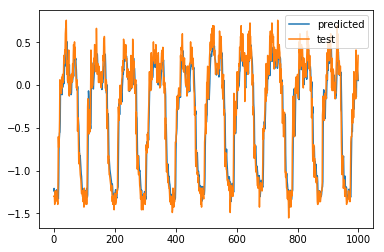

In [29]:
plot_predicted, = plt.plot(predicted,label='predicted')
plot_test, = plt.plot(y['test'],label='test')
plt.legend(handles=[plot_predicted,plot_test])
plt.show()

### graph of model

![graph](log/elec/graph_rnn.png)